# Healthcare Providers Data For Anomaly Detection
My project aim is to find possible fraud in the Medicare dataset. Firstly, we have to clarify some definitions and names and then we will look at the dataset. According to Wikipedia, "Medicare is a government national health insurance program in the United States, begun in 1965 under the Social Security Administration (SSA) and now administered by the Centers for Medicare and Medicaid Services (CMS)" 
This dataset, collected and published by CMS contains datapoint between 2012 and 2018. 
The dataset contains aggregated and modified (mainly due to privacy reasons) records. They aggregated these along the provider's identifier, the service identifier, and the place of the service. 
The dataset contains the most important information about the provider, for example, the name, place of service, address, and even the gender of the provider. The so-called HCPCS code identifies the specific medical service furnished by the provider. After these columns come the more interesting part. The data source contains the number of distinct Medicare beneficiaries receiving the service and the number of distinct Medicare beneficiaries/per day services. The average of the Medicare allowed amount for the service shows how much the previously mentioned beneficiaries paid for the given service. Of course, this is just an average, but a couple of years ago this source also contained the standard deviation too, which was removed recently. 
The average of the charges that the provider submitted for the service shows is also important. 
The average amount that Medicare paid after deductible and coinsurance amounts have been deducted for the line item service are the amount that Medicare paid after deductible and coinsurance amounts have been deducted for the line item service. 

For more details please follow the link below.

https://www.cms.gov/research-statistics-data-and-systems/statistics-trends-and-reports/medicare-provider-charge-data/downloads/medicare-physician-and-other-supplier-puf-methodology.pdf

Furthermore, we should clarify what healthcare fraud means. I have found the following definition and example on the site of the FBI:
    
Fraud Committed by Medical Providers
- Double billing: Submitting multiple claims for the same service
- Phantom billing: Billing for a service visit or supplies the patient never received
- Unbundling: Submitting multiple bills for the same service
- Upcoding: Billing for a more expensive service than the patient actually received

Fraud Committed by Patients and Other Individuals
- Bogus marketing: Convincing people to provide their health insurance identification number and other personal information to bill for non-rendered services, steal their identity, or enroll them in a fake benefit plan
- Identity theft/identity swapping: Using another person’s health insurance or allowing another person to use your insurance
- Impersonating a health care professional: Providing or billing for health services or equipment without a license

soruce: https://www.fbi.gov/investigate/white-collar-crime/health-care-fraud

It is also important, we could only use unsupervised techniques because of the lack of any flag or column that indicates if a given row is a fraud or not. 

In [20]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.express as px
import timeit

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/abigel87/project_work/main/Healthcare%20Providers.csv")

In [3]:
print(df.shape)
#The data source has 100 000 rows and 27 columns

(100000, 27)


In [4]:
#check if column "index" is unique
df["index"].unique().shape[0]

100000

In [5]:
df["National Provider Identifier"].unique().shape
#The "National Provider Identifier" contains 89 508 unique Providers

(89508,)

In [6]:
#missing values
for c in df.columns:
    print(c + ": " + str(df[df[c]!=df[c]].shape[0]))

index: 0
National Provider Identifier: 0
Last Name/Organization Name of the Provider: 0
First Name of the Provider: 4255
Middle Initial of the Provider: 29331
Credentials of the Provider: 7209
Gender of the Provider: 4254
Entity Type of the Provider: 0
Street Address 1 of the Provider: 0
Street Address 2 of the Provider: 59363
City of the Provider: 0
Zip Code of the Provider: 0
State Code of the Provider: 0
Country Code of the Provider: 0
Provider Type: 0
Medicare Participation Indicator: 0
Place of Service: 0
HCPCS Code: 0
HCPCS Description: 0
HCPCS Drug Indicator: 0
Number of Services: 0
Number of Medicare Beneficiaries: 0
Number of Distinct Medicare Beneficiary/Per Day Services: 0
Average Medicare Allowed Amount: 0
Average Submitted Charge Amount: 0
Average Medicare Payment Amount: 0
Average Medicare Standardized Amount: 0


In [7]:
#There are two types of provider: I for Individual ans O for organization
df.groupby("Entity Type of the Provider")["index"].count()
#The results show that there are more individual providers than organization (95 746 vs 4254)
#This could be an important factor to assess whether individual or organized providers billed(?) more

Entity Type of the Provider
I    95746
O     4254
Name: index, dtype: int64

In [8]:
#Group datasource by provider's country
df.groupby("Country Code of the Provider")['index'].count()
# There are 6 poviders outside of US, this deserve more attention

Country Code of the Provider
DE        3
JP        2
TR        1
US    99994
Name: index, dtype: int64

In [9]:
#Do the same with provider type
prov_type = df.groupby("Provider Type")['index'].count()
#This contains 90 different type of providers
#Show the x-th most commont service in a barchart
print(prov_type)

Provider Type
Addiction Medicine                                     8
Advanced Heart Failure and Transplant Cardiology       1
All Other Suppliers                                   31
Allergy/ Immunology                                  308
Ambulance Service Provider                           327
                                                    ... 
Surgical Oncology                                     67
Thoracic Surgery                                     184
Undefined Physician type                              41
Urology                                             1794
Vascular Surgery                                     650
Name: index, Length: 90, dtype: int64


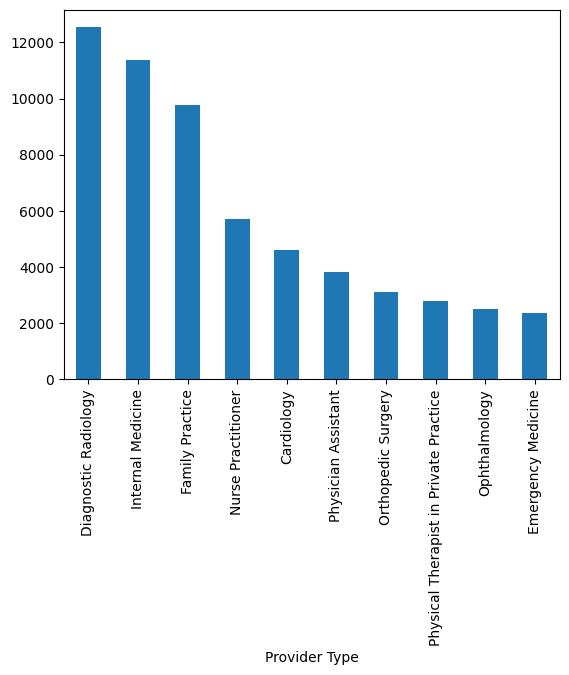

In [10]:
diagram_data = prov_type.nlargest(n=10)
diagram_data.plot.bar()
plt.show()

In [11]:
#We have to convert the numerical columns
df["Average Submitted Charge Amount"].dtype
#Object datetype because the values contain decimal and 1000 separators
#here is an examlpe
df.iloc[31]["Average Submitted Charge Amount"]

'1,440.3055556'

In [12]:
def replace_comma(x):
    return x.replace(",", "")

df["Number of Services"] = pd.to_numeric(df["Number of Services"].apply(lambda x: replace_comma(x)))
df["Number of Medicare Beneficiaries"] = pd.to_numeric(df["Number of Medicare Beneficiaries"].apply(lambda x: replace_comma(x)))
df["Number of Distinct Medicare Beneficiary/Per Day Services"] = pd.to_numeric(df["Number of Distinct Medicare Beneficiary/Per Day Services"].apply(lambda x: replace_comma(x)))

df["Average Medicare Allowed Amount"] = pd.to_numeric(df["Average Medicare Allowed Amount"].apply(lambda x: replace_comma(x)))
df["Average Submitted Charge Amount"] = pd.to_numeric(df["Average Submitted Charge Amount"].apply(lambda x: replace_comma(x)))
df["Average Medicare Payment Amount"] = pd.to_numeric(df["Average Medicare Payment Amount"].apply(lambda x: replace_comma(x)))
df["Average Medicare Standardized Amount"] = pd.to_numeric(df["Average Medicare Standardized Amount"].apply(lambda x: replace_comma(x)))

In [13]:
#the result of the function: unnecessary comma has disappeard and the type of the column changed to float64
df.iloc[31]["Average Submitted Charge Amount"]
df["Average Submitted Charge Amount"].dtype
print(df.iloc[31]["Average Submitted Charge Amount"])

1440.3055556


count    100000.000000
mean        101.434155
std         257.242779
min           0.010000
25%          24.270000
50%          65.095000
75%         113.160000
max       20494.000000
Name: Average Medicare Allowed Amount, dtype: float64

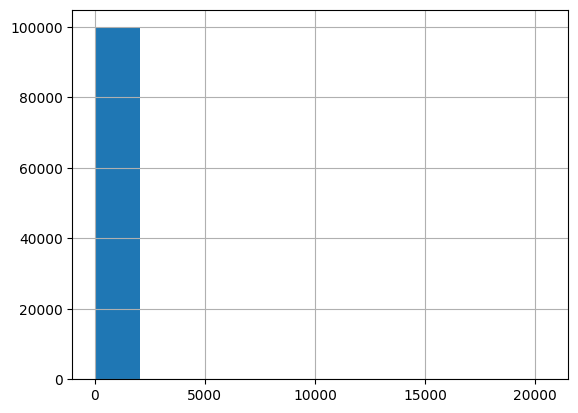

In [14]:
#More plots
#histograms of distributions
df["Average Medicare Allowed Amount"].hist()
#this returns a strange one-column histogram
df["Average Medicare Allowed Amount"].describe()

<AxesSubplot: >

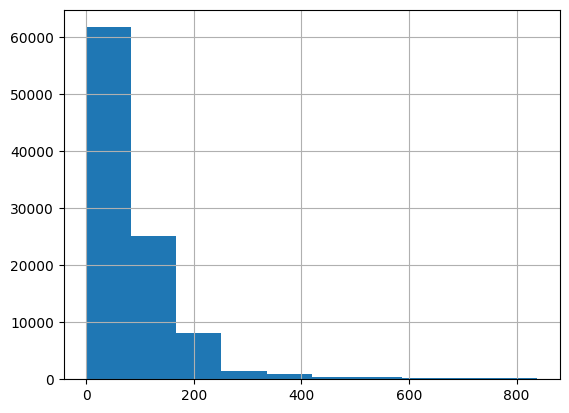

In [15]:
#I cut the upper 1% values off - those values deserves more attention.
df[df["Average Medicare Allowed Amount"] < np.percentile(df["Average Medicare Allowed Amount"], 99)]["Average Medicare Allowed Amount"].hist()

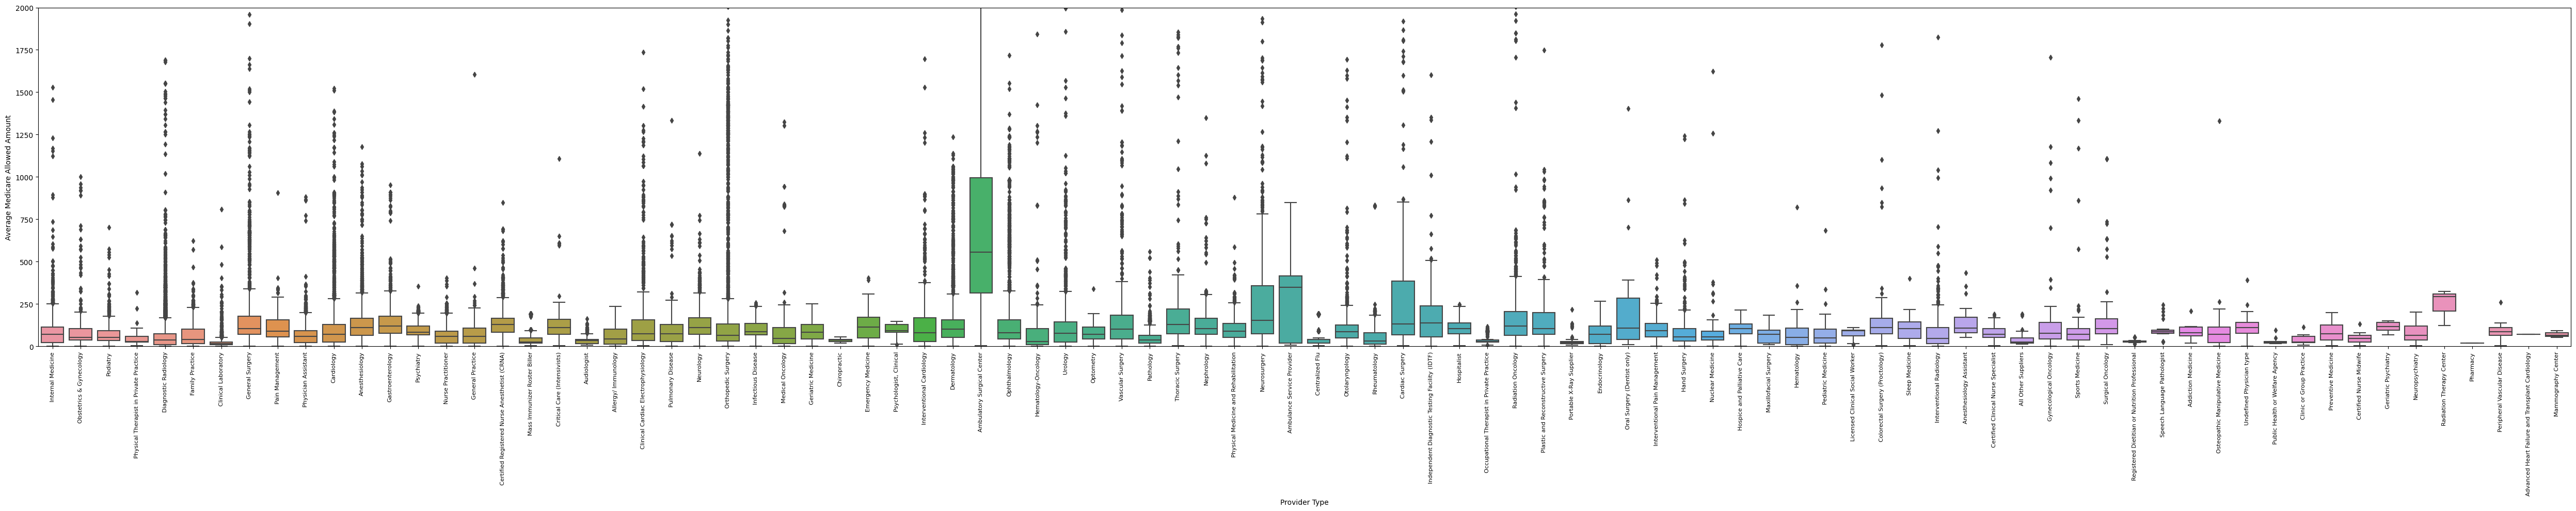

In [21]:
plt.figure(figsize=(50, 10))
ax = sns.boxplot(data=df, x="Provider Type", y="Average Medicare Allowed Amount")
ax.set(ylim=(0, 2000))
ax.margins(x = 1, tight = True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tick_params(axis='x', which='major', labelsize=8)
plt.tight_layout()

In [22]:
df["Average Submitted Charge Amount"].describe()

count    100000.000000
mean        354.550451
std        1062.608271
min           0.010000
25%          57.647876
50%         146.000000
75%         298.932111
max       62694.000000
Name: Average Submitted Charge Amount, dtype: float64

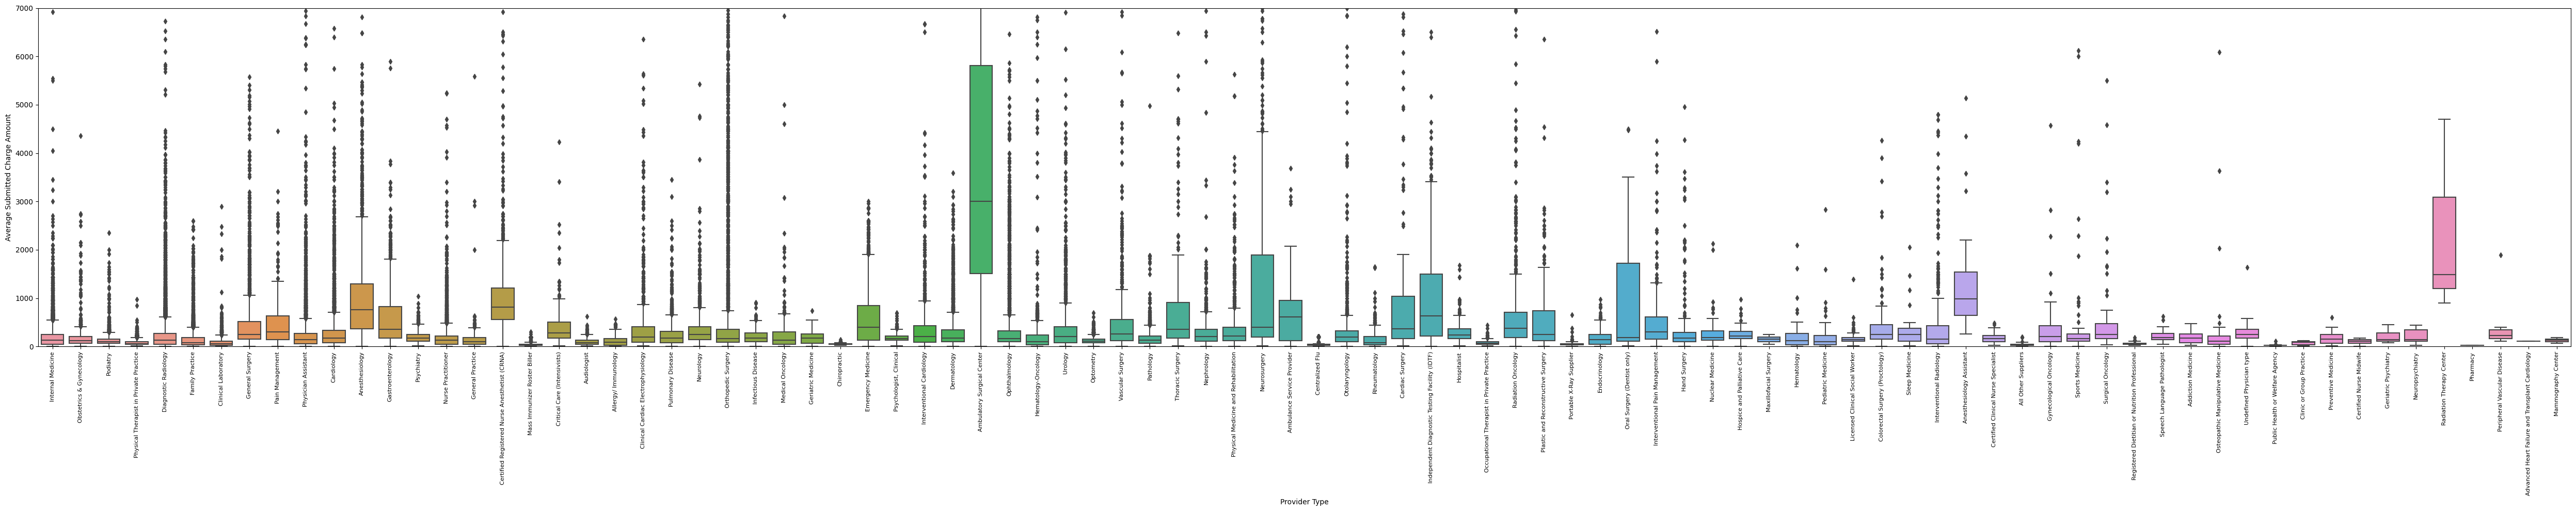

In [23]:
#plot for Average Submitted Charge Amount
plt.figure(figsize=(50, 10))
ax = sns.boxplot(data=df, x="Provider Type", y="Average Submitted Charge Amount")
ax.set(ylim=(0, 7000))
ax.margins(x = 1, tight = True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tick_params(axis='x', which='major', labelsize=8)
plt.tight_layout()

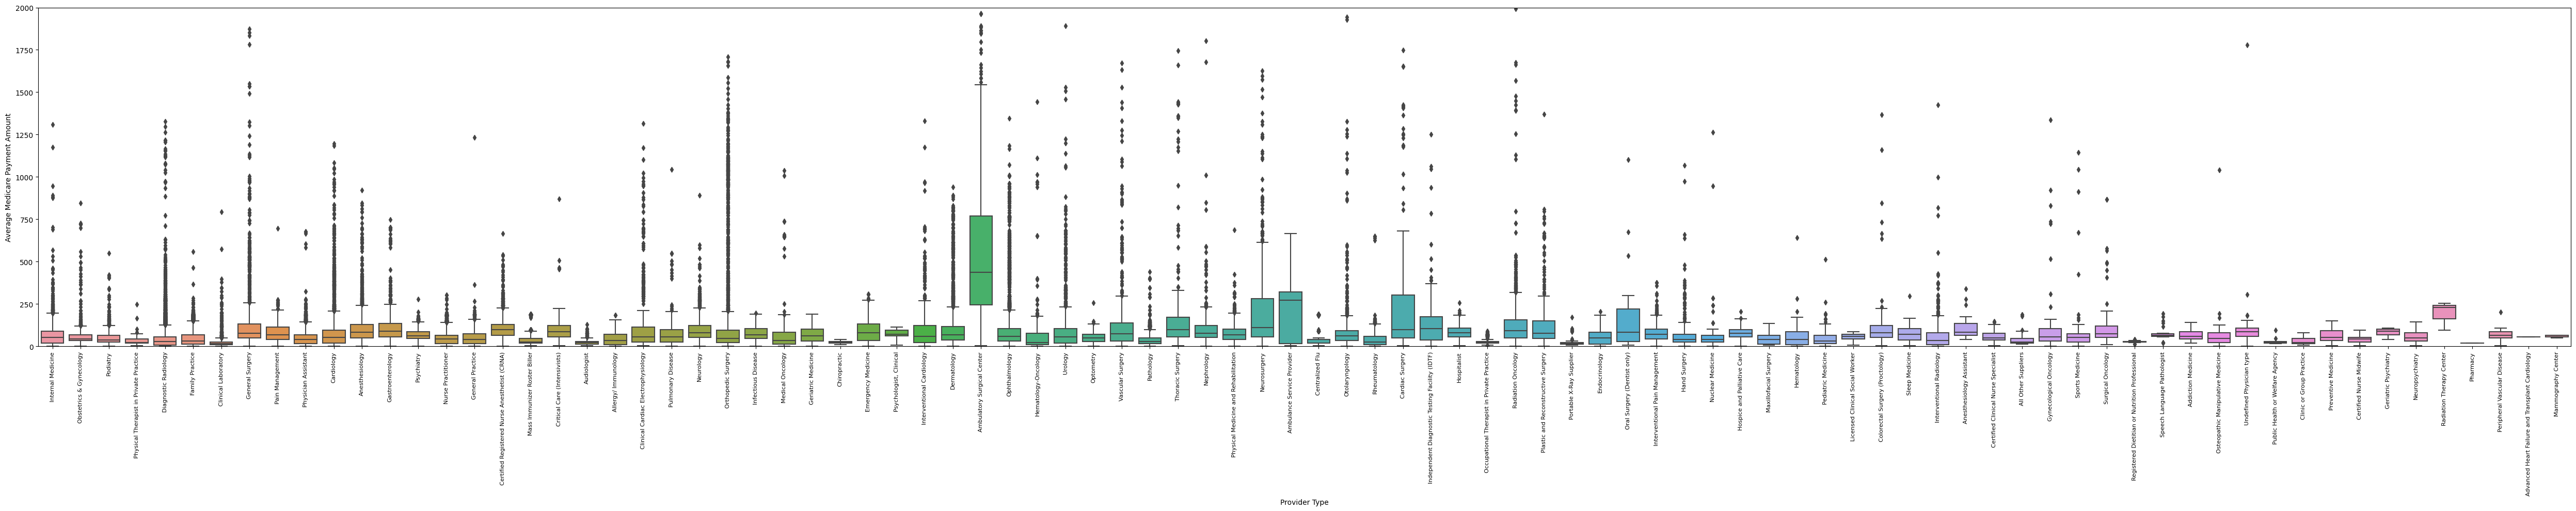

In [24]:
#plot for Average Medicare Payment Amount
plt.figure(figsize=(50, 10))
ax = sns.boxplot(data=df, x="Provider Type", y="Average Medicare Payment Amount")
ax.set(ylim=(0, 2000))
ax.margins(x = 1, tight = True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tick_params(axis='x', which='major', labelsize=8)
plt.tight_layout()

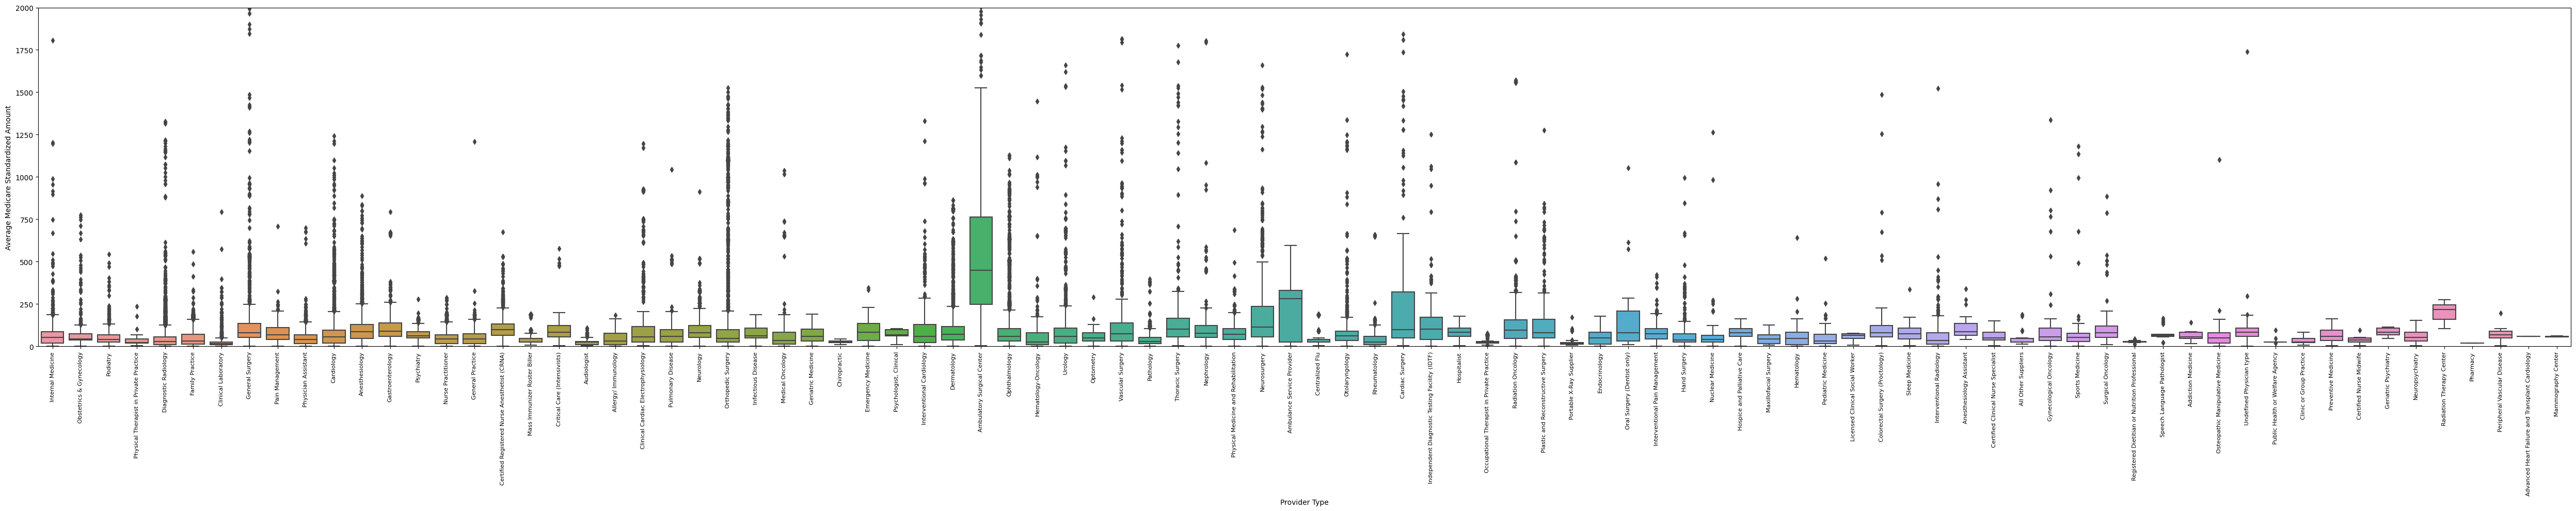

In [25]:
#plot for Average Medicare Standardized Amount
plt.figure(figsize=(50, 10))
ax = sns.boxplot(data=df, x="Provider Type", y="Average Medicare Standardized Amount")
ax.set(ylim=(0, 2000))
ax.margins(x = 1, tight = True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tick_params(axis='x', which='major', labelsize=8)
plt.tight_layout()

The previous graphs clearly show that there are outliers in every payment/charge category, and some services come with higher standard deviations than others.

<AxesSubplot: xlabel='Average Medicare Allowed Amount', ylabel='Entity Type of the Provider'>

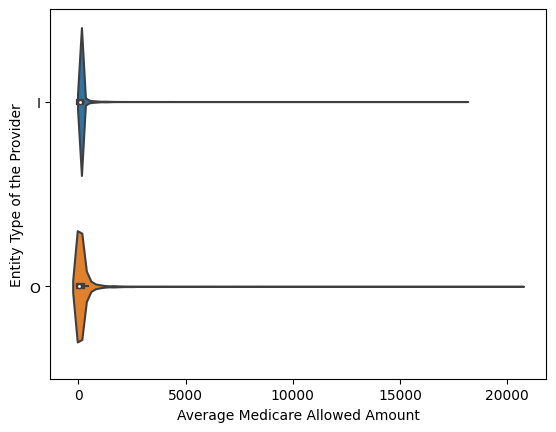

In [26]:
#lets visualize if there is a difference in distributon according to the type of the provider
sns.violinplot(data=df, x="Average Medicare Allowed Amount", y="Entity Type of the Provider")

In [27]:
#calculate distinct HCPCS Description of each provider
df_HCPCS = pd.DataFrame(columns=["prov_type", "hcpcs"])
for id, p in enumerate(df["Provider Type"].unique()):
    s = df[df["Provider Type"] == p]["HCPCS Description"].unique().shape[0]
    df_HCPCS.at[id, "prov_type"] = p
    df_HCPCS.at[id, "hcpcs"] = s

print(df_HCPCS.sort_values(by=["hcpcs"], ascending=False).head(10))

               prov_type hcpcs
0      Internal Medicine   533
5        Family Practice   444
14    Nurse Practitioner   436
9    Physician Assistant   428
6    Clinical Laboratory   406
4   Diagnostic Radiology   385
10            Cardiology   294
24    Orthopedic Surgery   284
7        General Surgery   236
35   Hematology-Oncology   206


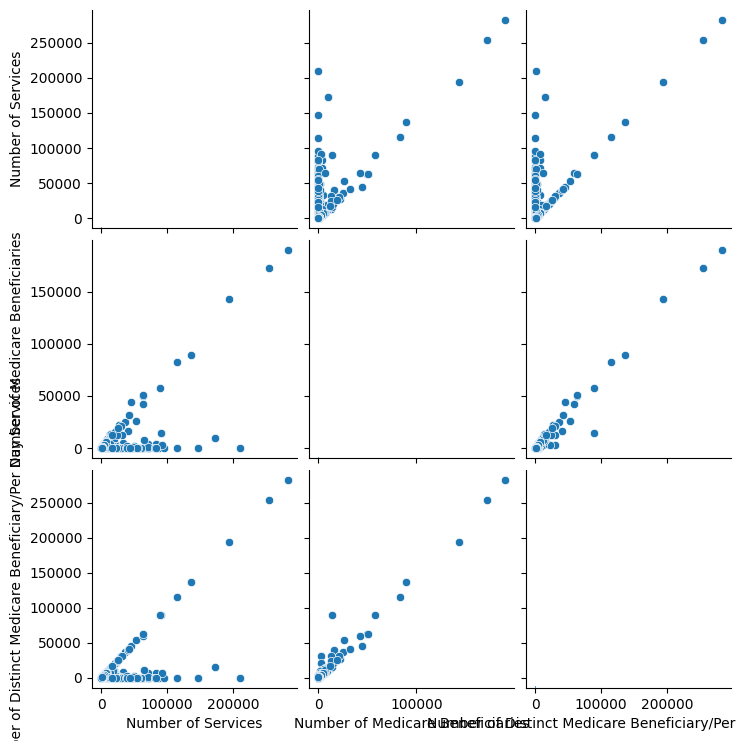

In [28]:
sns.pairplot(df[["Number of Services",
    "Number of Medicare Beneficiaries",
    "Number of Distinct Medicare Beneficiary/Per Day Services"]])

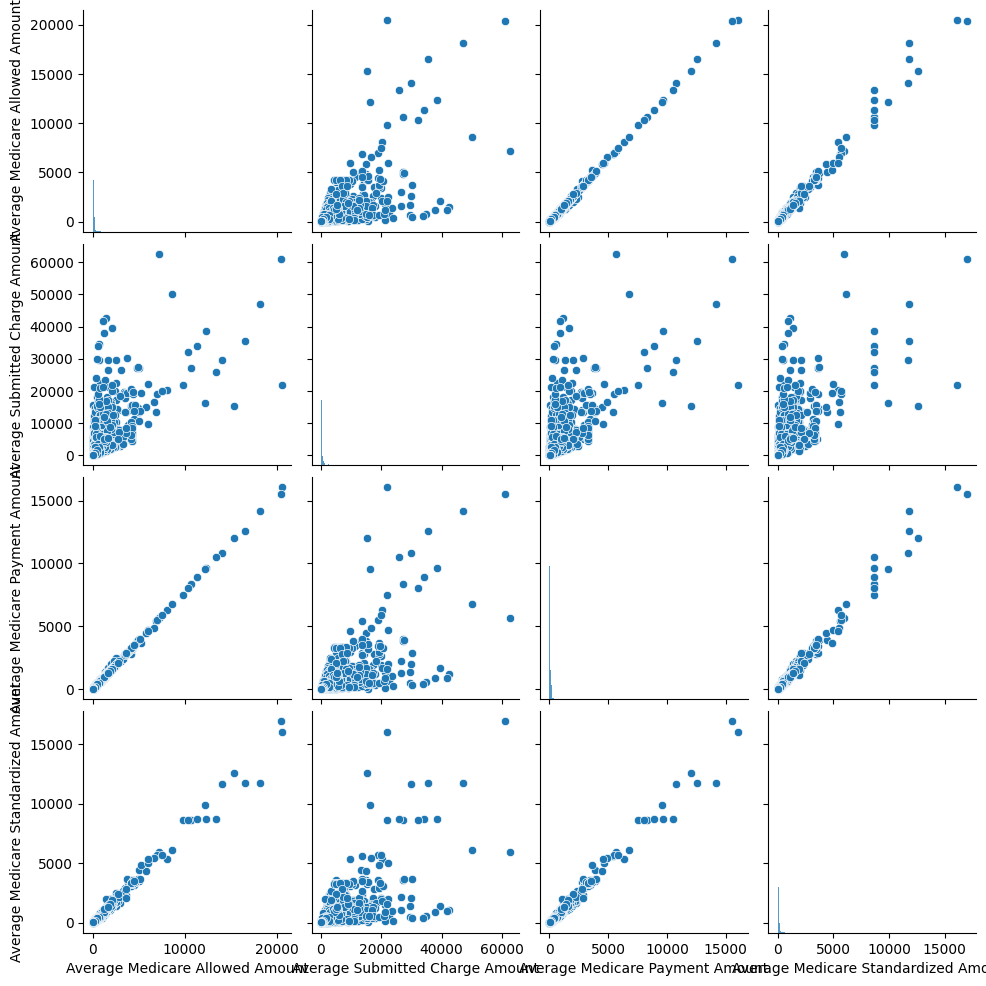

In [39]:
sns.pairplot(df[["Average Medicare Allowed Amount",
    "Average Submitted Charge Amount",
    "Average Medicare Payment Amount",
    "Average Medicare Standardized Amount"]])

In [40]:
df= df.astype({'Number of Services':'int','Number of Medicare Beneficiaries': 'int', 'Number of Distinct Medicare Beneficiary/Per Day Services': 'int', 'Average Medicare Allowed Amount' : 'int', 'Average Submitted Charge Amount' : 'int',  'Average Medicare Payment Amount': 'int',  'Average Medicare Standardized Amount': 'int'})

In [42]:
list_str_obj_cols = df.columns[df.dtypes == "object"].tolist()
for str_obj_col in list_str_obj_cols:
    df[str_obj_col] = df[str_obj_col].astype("category")

In [43]:
df_train = df.copy()
#I would like to keep the dataframe so I copy it. 

We should calculate the correlation between the columns to decide whether would be dropped.

In [46]:
corr = df_train.corr()
corr_abs = corr.abs()
upper_tri = corr_abs.where(np.triu(np.ones(corr_abs.shape),k=1).astype(bool))

C:\Users\PocsG\AppData\Local\Temp\ipykernel_8548\1192189489.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_train.corr()


I will drop one of those columns that have a higher correlation value than 0.95.

In [47]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(to_drop)
to_drop.remove("National Provider Identifier")
print(to_drop)

['National Provider Identifier', 'Number of Distinct Medicare Beneficiary/Per Day Services', 'Average Medicare Payment Amount', 'Average Medicare Standardized Amount']
['Number of Distinct Medicare Beneficiary/Per Day Services', 'Average Medicare Payment Amount', 'Average Medicare Standardized Amount']


In [48]:
df_train = df_train.drop(df_train[to_drop], axis=1)
df_train.shape

(100000, 24)

I am going to scale the numerical columns and I choose them with the following line of code.

In [50]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_train_num =df_train.select_dtypes(include=numerics)

The classification algorithms are often based on the measurement of distances between data points. This is the main reason to normalize the variables. 

In [54]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_train[df_train_num.columns] = scaler.fit_transform(df_train_num)

In [55]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
list_cat_cols = df_train.columns[df_train.dtypes == "category"].tolist()
list_cat_cols
for str_cat_col in list_cat_cols:
   df_train[str_cat_col] = encoder.fit_transform(df_train[str_cat_col])

One lase check

In [56]:
df_train.head()

,index,National Provider Identifier,Last Name/Organization Name of the Provider,First Name of the Provider,Middle Initial of the Provider,Credentials of the Provider,Gender of the Provider,Entity Type of the Provider,Street Address 1 of the Provider,Street Address 2 of the Provider,...,Provider Type,Medicare Participation Indicator,Place of Service,HCPCS Code,HCPCS Description,HCPCS Drug Indicator,Number of Services,Number of Medicare Beneficiaries,Average Medicare Allowed Amount,Average Submitted Charge Amount
0,0.891090,0.897077,39468,10215,29,667,0,0,9763,3452,...,39,1,0,2251,967,0,0.000057,0.000068,0.009759,0.004865
1,0.340621,0.346668,18353,12477,18,667,0,0,25436,10024,...,54,1,1,2374,2054,0,0.000580,0.000862,0.006002,0.008741
2,0.304824,0.306889,10622,9592,25,438,1,0,16839,6156,...,71,1,1,2295,665,0,0.000074,0.000011,0.004392,0.002472
3,0.771244,0.775276,12995,5036,29,956,1,0,39461,10024,...,39,1,1,1329,2330,0,0.000032,0.000037,0.000146,0.000080
4,0.075752,0.071340,29475,773,7,410,1,0,48417,7639,...,39,1,1,2163,973,0,0.000078,0.000068,0.001269,0.000638


In [57]:
from pyod.models.abod import ABOD
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
from pyod.models.cblof import CBLOF
from pyod.models.copod import COPOD
from pyod.models.lof import LOF
from pyod.models.pca import PCA
from pyod.models.hbos import HBOS
from pyod.models.sos import SOS
from pyod.models.ecod import ECOD

These classification algorithms receive an important argument. This is the expected ratio of anomalies among the dataset. I made some quick research to find this ratio but I have not found a straight answer. "The National Health Care Anti-Fraud Association (NHCAA) conservatively estimates that 3 percent of all health care spending, or $60 billion, is lost to health care fraud." The United States Sentencing Commission issued a paper that contains the followings: "IN FY 2021, 57,287 cases were reported to the U.S. Sentencing Commision" and "4,235 of this involved theft, property destruction, and fraud". The ratio in the lase case is 7 percent, however, I assume that they reported the suspicious cases in the first place. So, I could accept the 3 percent, and I will use this ratio in the following.

Source:

https://www.ussc.gov/sites/default/files/pdf/research-and-publications/quick-facts/Health_Care_Fraud_FY21.pdf
http://lexisnexis.com/risk/downloads/idm/bending-the-cost-curve-analytic-driven-enterprise-fraud-control.pdf

In [58]:
outlier_percent = 0.03

I am going to use the following models to detect anomalies in the data frame. 

- "ABOD" : Angle-based outlier detection
- "KNN" : K-Nearest Neighbor
- "Isolation Forest"
- "LOF" : Local Outlier Factor
- "COPOD" : Copula-Based Outlier Detection
- "PCA" : Principal Component Analysis
- "HBOS" : Histogram-based Outlier Score
- "ECOD" : Empirical Cumulative Distribution Functions for Outlier Detection

In [60]:
result_df = pd.DataFrame({"Package Name":[],"Model Name":[],"Time Taken in Seconds":[],"No.Of Data Points":[],"No.Of Outliers":[],"Percentage":[]})
package_name = "PyOD"
result_noniqr = pd.DataFrame({"Package Name":[],"Model Name":[],"Outliers Predicted":[],"Non-Outliers Predicted":[]})

outlier_df = pd.DataFrame()
n_points = df_train.shape[0]

In [61]:
def makeDataFrameNonIQR(clf_name, pred):
    global result_noniqr
    predicted = df_train[pred == 1]
    predicted_no = df_train[pred == 0]
    outliers_predicted = sum(pred == 1)
    nonoutliers_predicted = sum(pred == 0)

    cur = {"Package Name": package_name, "Model Name": clf_name, "Outliers Predicted": outliers_predicted,
           "Non-Outliers Predicted": nonoutliers_predicted}
    result_noniqr = result_noniqr.append(cur, ignore_index=True)

### ABOD

The ABOD algorithm (Angle-based outlier detection) calculates the angles between data points and the other variables. Then it calculates the variance of these angles. Points for which this variance is below a predetermined threshold (outlier_percent) consider anomalies. 

C:\Users\PocsG\AppData\Local\Temp\ipykernel_8548\71286646.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_noniqr = result_noniqr.append(cur, ignore_index=True)


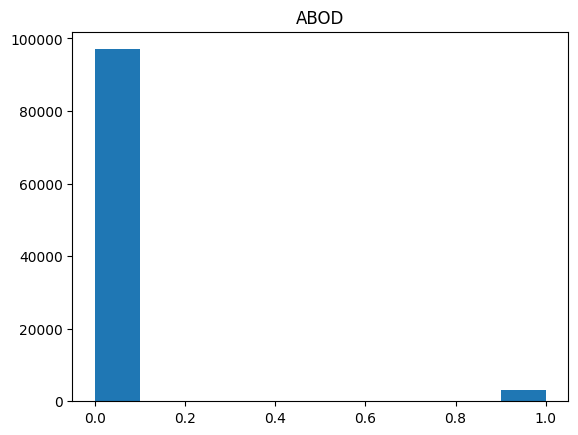

C:\Users\PocsG\AppData\Local\Temp\ipykernel_8548\2258303964.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(cur_model, ignore_index=True)


In [62]:
clf_name = "ABOD"
clf = ABOD(contamination=outlier_percent)

#for clf_name, clf in model_dict.items():
# Starting Timer
start_time = timeit.default_timer()
clf.fit(df_train)
y_decision_scores = clf.decision_scores_
# Stopping Timer
stop_time = timeit.default_timer()

makeDataFrameNonIQR(clf_name, clf.labels_)

diff = np.round(stop_time - start_time, 2)
labels = clf.labels_
n_outliers = np.count_nonzero(labels)
predicted_outlier_percent = np.round((n_outliers / n_points) * 100, 0)

fig = plt.figure()
plt.title(clf_name)
plt.hist(labels)
plt.show()

outlier_df[clf_name + " Outliers"] = labels
outlier_df[clf_name + " Distance"] = np.round(y_decision_scores, 2)

cur_model = {"Package Name": package_name, "Model Name": clf_name, "Time Taken in Seconds": diff,
             "No.Of Data Points": n_points, "No.Of Outliers": n_outliers, "Percentage": predicted_outlier_percent}
result_df = result_df.append(cur_model, ignore_index=True)

### KNN

The KNN algorithms classify the data points based on their neighbor's properties. That is why the key parameter in KNN is the number of neighbors, which determines how many of neighbors to use for calculating distances from the point of measurement. 
The default setting of the PYOD library is 5, which I do not modify. 

C:\Users\PocsG\AppData\Local\Temp\ipykernel_8548\71286646.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_noniqr = result_noniqr.append(cur, ignore_index=True)


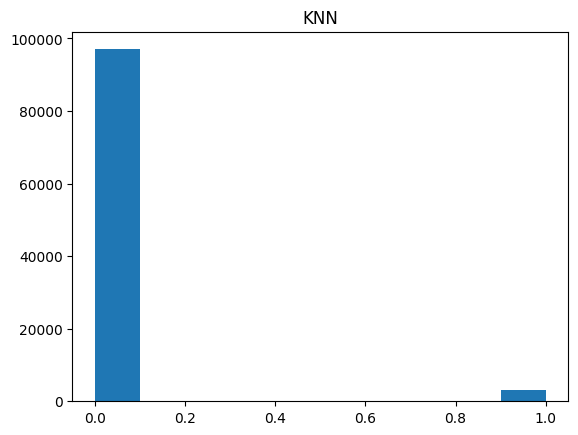

C:\Users\PocsG\AppData\Local\Temp\ipykernel_8548\2989956098.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(cur_model, ignore_index=True)


In [63]:
clf_name = "KNN"
clf = KNN(contamination=outlier_percent)

#for clf_name, clf in model_dict.items():
# Starting Timer
start_time = timeit.default_timer()
clf.fit(df_train)
y_decision_scores = clf.decision_scores_
# Stopping Timer
stop_time = timeit.default_timer()

makeDataFrameNonIQR(clf_name, clf.labels_)

diff = np.round(stop_time - start_time, 2)
labels = clf.labels_
n_outliers = np.count_nonzero(labels)
predicted_outlier_percent = np.round((n_outliers / n_points) * 100, 0)

fig = plt.figure()
plt.title(clf_name)
plt.hist(labels)
plt.show()

outlier_df[clf_name + " Outliers"] = labels
outlier_df[clf_name + " Distance"] = np.round(y_decision_scores, 2)

cur_model = {"Package Name": package_name, "Model Name": clf_name, "Time Taken in Seconds": diff,
             "No.Of Data Points": n_points, "No.Of Outliers": n_outliers, "Percentage": predicted_outlier_percent}
result_df = result_df.append(cur_model, ignore_index=True)


### Isolation Forest

The Isolation forest algorithm is a very popular approach among data scientists. It uses binary trees in order to detect anomalies in a data source. This algorithm creates partitions by randomly selecting features and then - also randomly - selecting a split value between the maximum and minimum value of the given attributes. Then, the algorithms contain these steps until the very leaf of the tree represents a single data point from the dataset. 
Theoretically, if we have anomalies in our datasets, these values should be closer to the root of the three.

C:\Users\PocsG\AppData\Local\Temp\ipykernel_8548\71286646.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_noniqr = result_noniqr.append(cur, ignore_index=True)


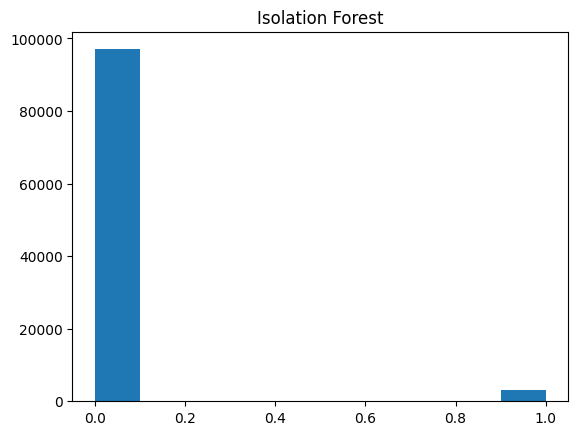

C:\Users\PocsG\AppData\Local\Temp\ipykernel_8548\1733728050.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(cur_model, ignore_index=True)


In [66]:
clf_name = "Isolation Forest"
clf = IForest(contamination=outlier_percent)

#for clf_name, clf in model_dict.items():
# Starting Timer
start_time = timeit.default_timer()
clf.fit(df_train)
y_decision_scores = clf.decision_scores_
# Stopping Timer
stop_time = timeit.default_timer()

makeDataFrameNonIQR(clf_name, clf.labels_)

diff = np.round(stop_time - start_time, 2)
labels = clf.labels_
n_outliers = np.count_nonzero(labels)
predicted_outlier_percent = np.round((n_outliers / n_points) * 100, 0)

fig = plt.figure()
plt.title(clf_name)
plt.hist(labels)
plt.show()

outlier_df[clf_name + " Outliers"] = labels
outlier_df[clf_name + " Distance"] = np.round(y_decision_scores, 2)

cur_model = {"Package Name": package_name, "Model Name": clf_name, "Time Taken in Seconds": diff,
             "No.Of Data Points": n_points, "No.Of Outliers": n_outliers, "Percentage": predicted_outlier_percent}
result_df = result_df.append(cur_model, ignore_index=True)

### LOF

The LOF of Local Outlier Factor calculates the local density deviation of a given data point with respect to its neighbors. This algorithm considers a data point as an outlier if it has a significantly lower density than its neighbors.  

C:\Users\PocsG\AppData\Local\Temp\ipykernel_8548\71286646.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_noniqr = result_noniqr.append(cur, ignore_index=True)


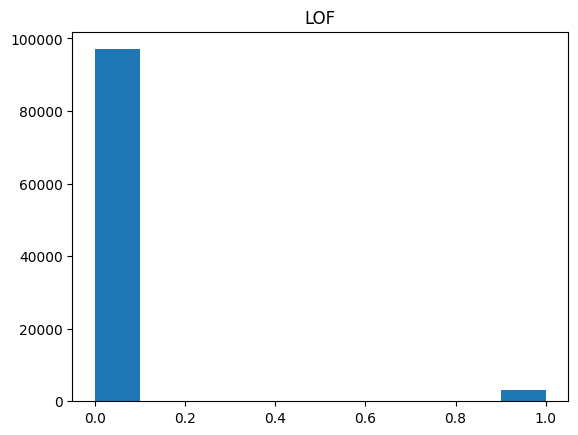

C:\Users\PocsG\AppData\Local\Temp\ipykernel_8548\1689156707.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(cur_model, ignore_index=True)


In [67]:
clf_name = "LOF"
clf = LOF(contamination=outlier_percent)

#for clf_name, clf in model_dict.items():
# Starting Timer
start_time = timeit.default_timer()
clf.fit(df_train)
y_decision_scores = clf.decision_scores_
# Stopping Timer
stop_time = timeit.default_timer()

makeDataFrameNonIQR(clf_name, clf.labels_)

diff = np.round(stop_time - start_time, 2)
labels = clf.labels_
n_outliers = np.count_nonzero(labels)
predicted_outlier_percent = np.round((n_outliers / n_points) * 100, 0)

fig = plt.figure()
plt.title(clf_name)
plt.hist(labels)
plt.show()

outlier_df[clf_name + " Outliers"] = labels
outlier_df[clf_name + " Distance"] = np.round(y_decision_scores, 2)

cur_model = {"Package Name": package_name, "Model Name": clf_name, "Time Taken in Seconds": diff,
             "No.Of Data Points": n_points, "No.Of Outliers": n_outliers, "Percentage": predicted_outlier_percent}
result_df = result_df.append(cur_model, ignore_index=True)

### COPOD

The COPOD or Copula-Based Outlier Detection is a new algorithm for anomaly detection. 
This algorithm fit left and right tail empirical cumulative function and then calculates the skewness of every column in the dataset. Then, using the previously calculated values it computes the left-tail and right-tail empirical copula and also calculates the skewness-corrected empirical copula values for each row. 
Finally, it computes the anomaly scores for each row of the dataset based on the previously calculated values. 
The anomaly score for a row is the maximum value from
-  sum the negative log of left tail empirical copula
-  sum the negative log of right tail empirical copula
- sum the negative log of skewness corrected empirical copula

C:\Users\PocsG\AppData\Local\Temp\ipykernel_8548\71286646.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_noniqr = result_noniqr.append(cur, ignore_index=True)


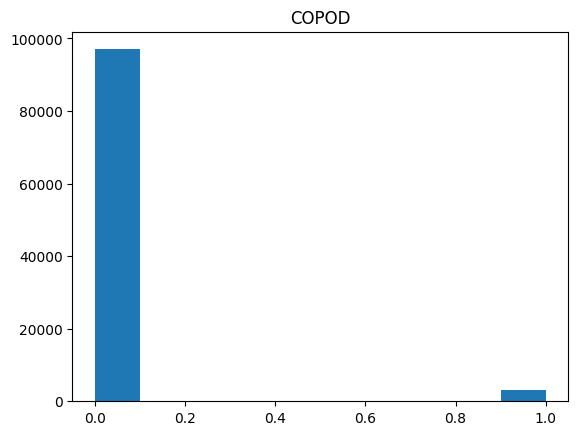

C:\Users\PocsG\AppData\Local\Temp\ipykernel_8548\1285663443.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(cur_model, ignore_index=True)


In [68]:
clf_name = "COPOD"
clf = COPOD(contamination=outlier_percent)

#for clf_name, clf in model_dict.items():
# Starting Timer
start_time = timeit.default_timer()
clf.fit(df_train)
y_decision_scores = clf.decision_scores_
# Stopping Timer
stop_time = timeit.default_timer()

makeDataFrameNonIQR(clf_name, clf.labels_)

diff = np.round(stop_time - start_time, 2)
labels = clf.labels_
n_outliers = np.count_nonzero(labels)
predicted_outlier_percent = np.round((n_outliers / n_points) * 100, 0)

fig = plt.figure()
plt.title(clf_name)
plt.hist(labels)
plt.show()

outlier_df[clf_name + " Outliers"] = labels
outlier_df[clf_name + " Distance"] = np.round(y_decision_scores, 2)

cur_model = {"Package Name": package_name, "Model Name": clf_name, "Time Taken in Seconds": diff,
             "No.Of Data Points": n_points, "No.Of Outliers": n_outliers, "Percentage": predicted_outlier_percent}
result_df = result_df.append(cur_model, ignore_index=True)

### PCA

C:\Users\PocsG\AppData\Local\Temp\ipykernel_8548\71286646.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_noniqr = result_noniqr.append(cur, ignore_index=True)


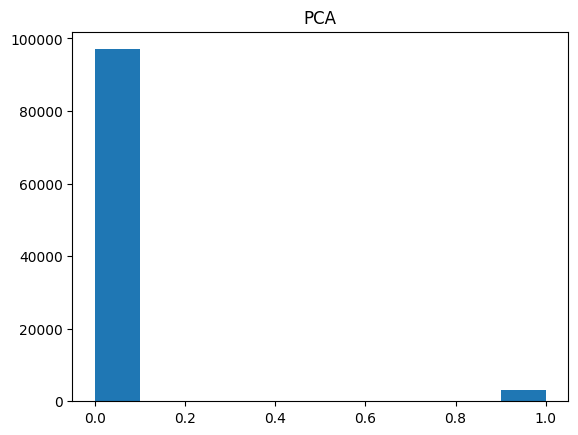

C:\Users\PocsG\AppData\Local\Temp\ipykernel_8548\1689958892.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(cur_model, ignore_index=True)


In [69]:
clf_name = "PCA"
clf = PCA(contamination=outlier_percent)

#for clf_name, clf in model_dict.items():
# Starting Timer
start_time = timeit.default_timer()
clf.fit(df_train)
y_decision_scores = clf.decision_scores_
# Stopping Timer
stop_time = timeit.default_timer()

makeDataFrameNonIQR(clf_name, clf.labels_)

diff = np.round(stop_time - start_time, 2)
labels = clf.labels_
n_outliers = np.count_nonzero(labels)
predicted_outlier_percent = np.round((n_outliers / n_points) * 100, 0)

fig = plt.figure()
plt.title(clf_name)
plt.hist(labels)
plt.show()

outlier_df[clf_name + " Outliers"] = labels
outlier_df[clf_name + " Distance"] = np.round(y_decision_scores, 2)

cur_model = {"Package Name": package_name, "Model Name": clf_name, "Time Taken in Seconds": diff,
             "No.Of Data Points": n_points, "No.Of Outliers": n_outliers, "Percentage": predicted_outlier_percent}
result_df = result_df.append(cur_model, ignore_index=True)

### HBOS

C:\Users\PocsG\AppData\Local\Temp\ipykernel_8548\71286646.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_noniqr = result_noniqr.append(cur, ignore_index=True)


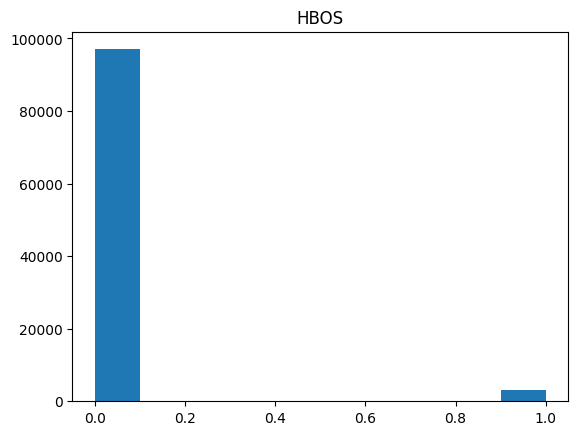

C:\Users\PocsG\AppData\Local\Temp\ipykernel_8548\2147646856.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(cur_model, ignore_index=True)


In [70]:
clf_name = "HBOS"
clf = HBOS(contamination=outlier_percent)

#for clf_name, clf in model_dict.items():
# Starting Timer
start_time = timeit.default_timer()
clf.fit(df_train)
y_decision_scores = clf.decision_scores_
# Stopping Timer
stop_time = timeit.default_timer()

makeDataFrameNonIQR(clf_name, clf.labels_)

diff = np.round(stop_time - start_time, 2)
labels = clf.labels_
n_outliers = np.count_nonzero(labels)
predicted_outlier_percent = np.round((n_outliers / n_points) * 100, 0)

fig = plt.figure()
plt.title(clf_name)
plt.hist(labels)
plt.show()

outlier_df[clf_name + " Outliers"] = labels
outlier_df[clf_name + " Distance"] = np.round(y_decision_scores, 2)

cur_model = {"Package Name": package_name, "Model Name": clf_name, "Time Taken in Seconds": diff,
             "No.Of Data Points": n_points, "No.Of Outliers": n_outliers, "Percentage": predicted_outlier_percent}
result_df = result_df.append(cur_model, ignore_index=True)


### ECOD

C:\Users\PocsG\AppData\Local\Temp\ipykernel_8548\71286646.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_noniqr = result_noniqr.append(cur, ignore_index=True)


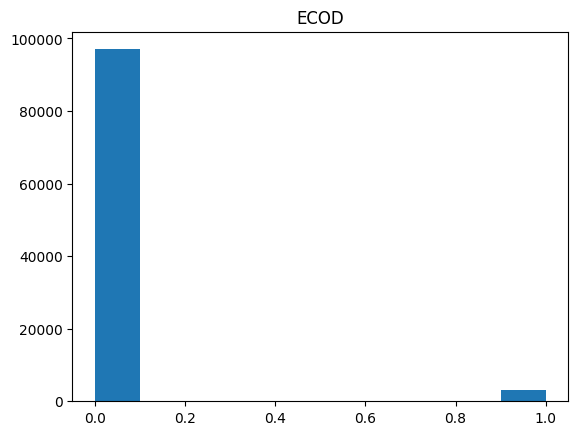

C:\Users\PocsG\AppData\Local\Temp\ipykernel_8548\687146390.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(cur_model, ignore_index=True)


In [71]:
clf_name = "ECOD"
clf = ECOD(contamination=outlier_percent)

#for clf_name, clf in model_dict.items():
# Starting Timer
start_time = timeit.default_timer()
clf.fit(df_train)
y_decision_scores = clf.decision_scores_
# Stopping Timer
stop_time = timeit.default_timer()

makeDataFrameNonIQR(clf_name, clf.labels_)

diff = np.round(stop_time - start_time, 2)
labels = clf.labels_
n_outliers = np.count_nonzero(labels)
predicted_outlier_percent = np.round((n_outliers / n_points) * 100, 0)

fig = plt.figure()
plt.title(clf_name)
plt.hist(labels)
plt.show()

outlier_df[clf_name + " Outliers"] = labels
outlier_df[clf_name + " Distance"] = np.round(y_decision_scores, 2)

cur_model = {"Package Name": package_name, "Model Name": clf_name, "Time Taken in Seconds": diff,
             "No.Of Data Points": n_points, "No.Of Outliers": n_outliers, "Percentage": predicted_outlier_percent}
result_df = result_df.append(cur_model, ignore_index=True)

In [72]:
from matplotlib.patches import Polygon

outlier_flag_col = []
for i in outlier_df.columns:
    if "Outliers" in i:
        outlier_flag_col.append(i)

print(outlier_flag_col)

['ABOD Outliers', 'KNN Outliers', 'Isolation Forest Outliers', 'LOF Outliers', 'COPOD Outliers', 'PCA Outliers', 'HBOS Outliers', 'ECOD Outliers']


In [73]:
outlier_df["nr_of_match"] = outlier_df[outlier_flag_col].sum(axis=1)
outlier_df["nr_of_match"].max()

outlier_df_filt = outlier_df[outlier_df["nr_of_match"]>7]
outlier_df_filt.shape

(13, 17)

I am going to consider a record as an anomaly if every algorithm that I have run previously detects it. I know that this is a strict criterion, but my main goal is to find an applicable solution. I assume that it could be easier to assess the efficiency of this method if the detected rows proved to be anomalies.

In [82]:
def create_boxplot_chart2(outlier_list, boxplot_cols):

    data = df[boxplot_cols]

    fig, ax1 = plt.subplots(figsize=(10, 6))
    fig.canvas.manager.set_window_title('Selected line item')
    fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

    bp = ax1.boxplot(data, notch=False, sym='+', vert=True, whis=1.5)
    plt.setp(bp['boxes'], color='black')
    plt.setp(bp['whiskers'], color='black')
    plt.setp(bp['fliers'], color='red', marker='+')

    ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
                   alpha=0.5)

    ax1.set(
        axisbelow=True,  # Hide the grid behind plot objects
        title='Relative position of the outlier to similar type of services',
        ylabel='Value',
    )


    box_colors = ['aqua', 'royalblue', 'blue', 'darkorchid', 'purple', 'deeppink']
    num_boxes = len(data.columns)
    medians = np.empty(num_boxes)

    for box_id, col_names in enumerate(data.columns):
        box = bp['boxes'][box_id]
        box_x = []
        box_y = []
        for j in range(5):
            box_x.append(box.get_xdata()[j])
            box_y.append(box.get_ydata()[j])
        box_coords = np.column_stack([box_x, box_y])
        ax1.add_patch(Polygon(box_coords, facecolor=box_colors[box_id]))

        for o in outlier_list:
            ax1.plot(box_id+1, data[data.index == o][col_names].values[0], color='w', marker='*', markeredgecolor='red', markersize=12)

    ax1.set_xlim(0.5, num_boxes + 0.5)
    top = np.percentile(data[data.idxmax(axis=1).values[0]],95)
    bottom = -5
    ax1.set_ylim(bottom, top)
    ax1.set_xticklabels(boxplot_cols, rotation=0, fontsize=8, wrap=True)
    plt.show()


This function creates boxplots of each variable and then it shows the detected point on it. 
I think this way is more useful and easier to understand than a scatter plot with thousands of points. 

In [83]:
boxplot_cols = ['Average Medicare Allowed Amount', 'Average Submitted Charge Amount',
       'Average Medicare Payment Amount',
       'Average Medicare Standardized Amount']

boxplot_cols2 = ['Number of Services', 'Number of Medicare Beneficiaries',
       'Number of Distinct Medicare Beneficiary/Per Day Services',]

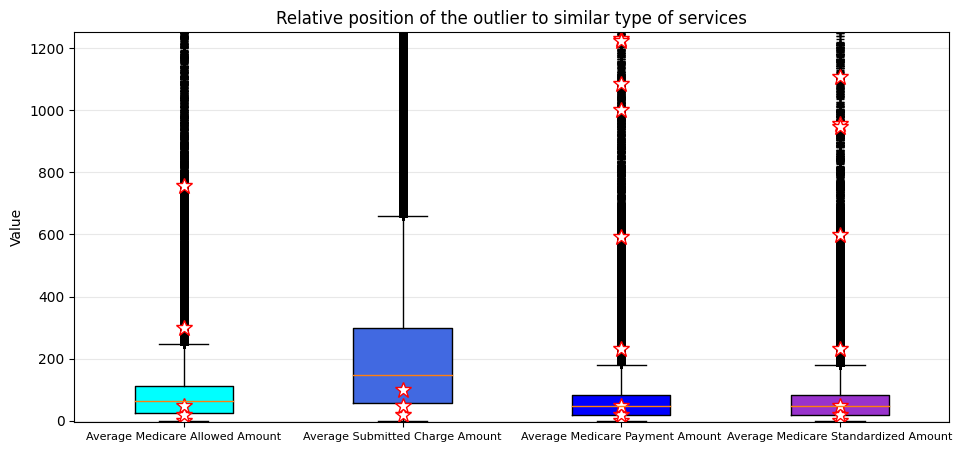

In [84]:
outlier_list = outlier_df_filt.index.tolist()
create_boxplot_chart2(outlier_list, boxplot_cols)

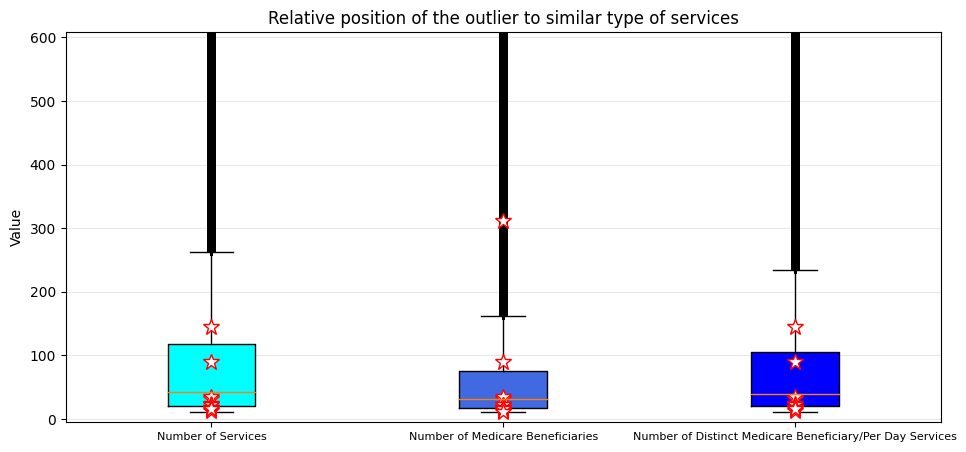

In [85]:
create_boxplot_chart2(outlier_list, boxplot_cols2)

If this work was not only a project I would consult with a more experienced analyst to assess the efficiency of this method. The low number of anomalies makes it possible to decide if this method is useful or if we have only found a unique pattern in the dataset.